In [1]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 4.3 MB/s 
     |████████████████████████████████| 596 kB 60.9 MB/s 
     |████████████████████████████████| 3.3 MB 61.2 MB/s 
     |████████████████████████████████| 61 kB 666 kB/s 
     |████████████████████████████████| 895 kB 57.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

In [3]:
model = AutoModelForSequenceClassification.from_pretrained("klue/roberta-base")
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-base")

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifie

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_data_df = pd.read_csv("/content/drive/MyDrive/Final project/동형이의어_구별/NIKL_SKT_WiC_Train.tsv", delimiter='\t')
dev_data_df = pd.read_csv("/content/drive/MyDrive/Final project/동형이의어_구별/NIKL_SKT_WiC_Dev.tsv", delimiter='\t')

train_data_df.head() # 시작점은 0부터 시작

,ID,Target,SENTENCE1,SENTENCE2,ANSWER,start_s1,end_s1,start_s2,end_s2
0,1,단정,그의 죽음은 타살로 단정이 되었다.,단정이 된 교실은 정돈되어 있다.,False,11,13,0,2
1,2,단수,현대 생활에서 단전과 단수의 고통은 겪어 보지 않으면 짐작도 못한다.,사업자를 단수로 할지 복수로 할지를 놓고 관계자들 사이에 입씨름이 벌어졌다.,False,12,14,5,7
2,3,화성,"화성은 밤과 낮, 하루의 길이와 계절의 변화가 지구와 매우 비슷하다.",화성은 서양 음악을 이루는 중요한 요소이다.,False,0,2,0,2
3,4,자전,달의 자전 주기는 달이 지구의 둘레를 공전하는 주기와 같다.,태양계의 모든 행성은 자전을 한다.,True,3,5,12,14
4,5,동지,오늘의 적이 내일은 동지가 될 수 있다.,동지에 무와 감자를 나누어 심었다.,False,11,13,0,2


In [6]:
train_data_df.columns = ["ID", "Target", "sentence_first", "sentence_second", "answer", "start1", "end1", "start2", "end2"]
dev_data_df.columns = ["ID", "Target", "sentence_first", "sentence_second", "answer", "start1", "end1", "start2", "end2"]

In [7]:
train_data_df["answer"] = train_data_df["answer"].replace(False, "0")
train_data_df["answer"] = train_data_df["answer"].replace(True, "1")

dev_data_df["answer"] = dev_data_df["answer"].replace(False, "0")
dev_data_df["answer"] = dev_data_df["answer"].replace(True, "1")

train_data_df.head()

,ID,Target,sentence_first,sentence_second,answer,start1,end1,start2,end2
0,1,단정,그의 죽음은 타살로 단정이 되었다.,단정이 된 교실은 정돈되어 있다.,0,11,13,0,2
1,2,단수,현대 생활에서 단전과 단수의 고통은 겪어 보지 않으면 짐작도 못한다.,사업자를 단수로 할지 복수로 할지를 놓고 관계자들 사이에 입씨름이 벌어졌다.,0,12,14,5,7
2,3,화성,"화성은 밤과 낮, 하루의 길이와 계절의 변화가 지구와 매우 비슷하다.",화성은 서양 음악을 이루는 중요한 요소이다.,0,0,2,0,2
3,4,자전,달의 자전 주기는 달이 지구의 둘레를 공전하는 주기와 같다.,태양계의 모든 행성은 자전을 한다.,1,3,5,12,14
4,5,동지,오늘의 적이 내일은 동지가 될 수 있다.,동지에 무와 감자를 나누어 심었다.,0,11,13,0,2


In [8]:
print(len(train_data_df))
print(len(dev_data_df))

7748
1166


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(26)
np.random.seed(26)
torch.manual_seed(26)
model.to(device) # Send the model to the GPU if we have one
learning_rate = 1e-5
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

In [10]:
def encode_data(tokenizer, sentence_firsts, sentence_seconds, max_length,
                start_positions1, start_positions2, end_positions1, end_positions2):

    input_ids = []
    attention_masks = []

    for sentence_first, sentence_second in zip(sentence_firsts, sentence_seconds):
        encoded_data = tokenizer.encode_plus(sentence_first, sentence_second, max_length=max_length, 
                                             pad_to_max_length=True, truncation_strategy="longest_first")
        encoded_pair = encoded_data["input_ids"]
        attention_mask = encoded_data["attention_mask"]

        input_ids.append(encoded_pair)
        attention_masks.append(attention_mask)     

    return np.array(input_ids), np.array(attention_masks)

In [11]:
sentence_firsts_train = train_data_df.sentence_first.values
sentence_seconds_train = train_data_df.sentence_second.values
answers_train = train_data_df.answer.values.astype(int)

start_positions1 = train_data_df.start1.values
start_positions2 = train_data_df.start2.values
end_positions1 = train_data_df.end1.values
end_positions2 = train_data_df.end2.values

start_positions1 = dev_data_df.start1.values
start_positions2 = dev_data_df.start2.values
end_positions1 = dev_data_df.end1.values
end_positions2 = dev_data_df.end2.values

sentence_firsts_dev = dev_data_df.sentence_first.values
sentence_seconds_dev = dev_data_df.sentence_second.values
answers_dev = dev_data_df.answer.values.astype(int)

In [12]:
max_seq_length = 512
input_ids_train, attention_masks_train = encode_data(tokenizer, sentence_firsts_train, sentence_seconds_train, 
                                                 max_seq_length,
                                                 start_positions1, start_positions2, 
                                                 end_positions1, end_positions2)
input_ids_dev, attention_masks_dev = encode_data(tokenizer, sentence_firsts_dev, sentence_seconds_dev, 
                                                 max_seq_length,
                                                 start_positions1, start_positions2, 
                                                 end_positions1, end_positions2)

train_features = (input_ids_train, attention_masks_train, answers_train)
dev_features = (input_ids_dev, attention_masks_dev, answers_dev)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [13]:
# Building Dataloaders
batch_size = 8

train_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in train_features]
dev_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in dev_features]

train_dataset = TensorDataset(*train_features_tensors)
dev_dataset = TensorDataset(*dev_features_tensors)

train_sampler = RandomSampler(train_dataset)
dev_sampler = SequentialSampler(dev_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=batch_size)

In [14]:
epochs = 5
grad_acc_steps = 1
train_loss_values = []
dev_acc_values = []

for _ in tqdm(range(epochs), desc="Epoch"):

  # Training
    epoch_train_loss = 0 # Cumulative loss
    model.train()
    model.zero_grad()

    for step, batch in enumerate(train_dataloader):

        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)     

        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks, labels=labels)

        loss = outputs[0]
        loss = loss / grad_acc_steps
        epoch_train_loss += loss.item()

        loss.backward()
      
        if (step+1) % grad_acc_steps == 0: # Gradient accumulation is over
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clipping gradients
            optimizer.step()
            model.zero_grad()

    epoch_train_loss = epoch_train_loss / len(train_dataloader)          
    train_loss_values.append(epoch_train_loss)

    # Evaluation
    epoch_dev_accuracy = 0 # Cumulative accuracy
    model.eval()

    for batch in dev_dataloader:
    
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2]
                
        with torch.no_grad():        
            outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                    
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
    
        predictions = np.argmax(logits, axis=1).flatten()
        labels = labels.numpy().flatten()
    
        epoch_dev_accuracy += np.sum(predictions == labels) / len(labels)

    epoch_dev_accuracy = epoch_dev_accuracy / len(dev_dataloader)
    dev_acc_values.append(epoch_dev_accuracy)  

Epoch: 100%|██████████| 5/5 [38:35<00:00, 463.13s/it]


In [15]:
train_loss_values

[0.6152671611530492,
 0.4042001976271163,
 0.2934629147902604,
 0.17745445954209238,
 0.12003908820587986]

In [16]:
dev_acc_values

[0.7200342465753424,
 0.7819634703196348,
 0.7825342465753424,
 0.8296232876712328,
 0.8373287671232876]

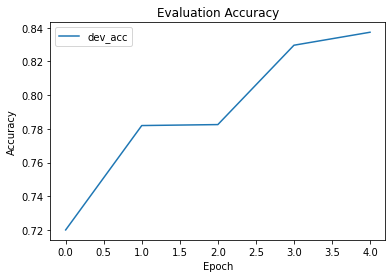

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(dev_acc_values, label="dev_acc")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
plt.legend()
plt.show()